In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
ticker = 'BTC-USD' # @param ["BTC-USD", "ETH-USD", "NVDA", "0700.HK", "2628.HK", "0941.HK", "0939.HK"] {allow-input: true}
startDate = '2020-01-01' #@param {type:"date"}

stock = yf.Ticker(ticker)

# get stocks daily data OHLCV (Open/High/Low/Close/Volume) from Yahoo Finance
df= stock.history(start=startDate)
df.index = pd.to_datetime(df.index)
df.index.name = 'Date'

In [3]:
df.shape

(2122, 7)

In [4]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-01 00:00:00+00:00,7194.892090,7254.330566,7174.944336,7200.174316,18565664997,0.0,0.0
2020-01-02 00:00:00+00:00,7202.551270,7212.155273,6935.270020,6985.470215,20802083465,0.0,0.0
2020-01-03 00:00:00+00:00,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,0.0,0.0
2020-01-04 00:00:00+00:00,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,0.0,0.0
2020-01-05 00:00:00+00:00,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,0.0,0.0


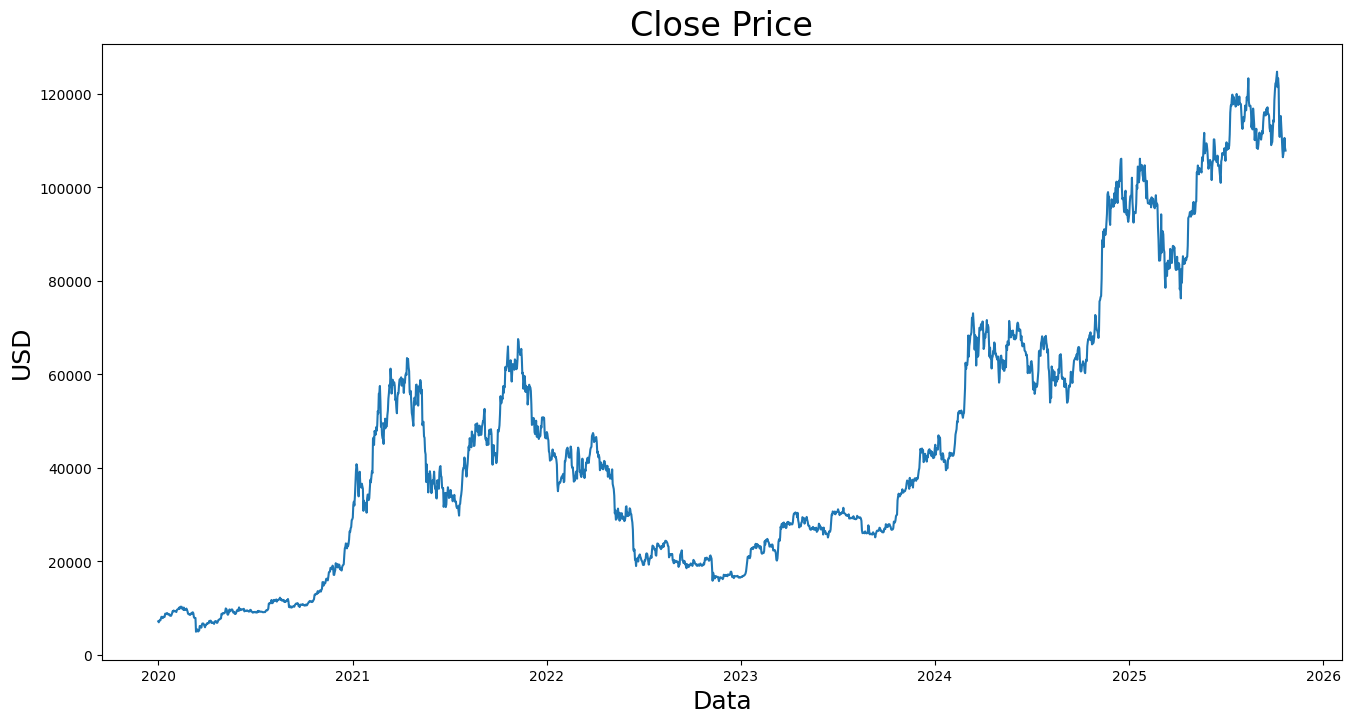

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

In [6]:
df = df.copy()
df = df[['Close']]

In [7]:
# Simple Moving Averages
df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['SMA_14'] = df['Close'].rolling(window=14).mean()
df['SMA_21'] = df['Close'].rolling(window=21).mean()

# Exponential Moving Averages
df['EMA_7'] = df['Close'].ewm(span=7, adjust=False).mean()
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()

# Rolling Standard Deviation (volatility)
df['Volatility_7'] = df['Close'].rolling(window=7).std()

In [8]:
df = df.fillna(method='bfill').fillna(0)

/tmp/ipython-input-2758468401.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(0)


In [9]:
#scaling the features
feature_cols = df.columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_cols])

In [10]:
training_data_len = math.ceil(len(scaled_data) * 0.7)
train_data = scaled_data[0:training_data_len]
X_train, y_train = [], []

In [11]:
#creating the training data using sequence of 60 timestamps
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, list(feature_cols).index('Close')])

X_train, y_train = np.array(X_train), np.array(y_train)

# Test set
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], df['Close'][training_data_len:].values

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i])

X_test = np.array(X_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1426, 60, 7)
y_train shape: (1426,)
X_test shape: (636, 60, 7)


In [12]:
len(X_train)

1426

In [13]:
X_train.shape
y_train.shape

(1426,)

In [64]:
#creating the model using tensorflow library
tf.random.set_seed(42)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [66]:
model.compile(optimizer='adam', loss='mse')

In [67]:
#training the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0021
Epoch 2/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6.2440e-04
Epoch 3/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4.5067e-04
Epoch 4/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3.5348e-04
Epoch 5/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 2.8721e-04
Epoch 6/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 2.5564e-04
Epoch 7/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 2.3495e-04
Epoch 8/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 2.1941e-04
Epoch 9/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 2.0748e-04
Epoch 10/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1.9898e-04


In [68]:
predictions_1 = model.predict(X_test)
dummy = np.zeros((len(predictions_1), len(feature_cols)))       # creating dummy features to apply inverse transform
dummy[:, feature_cols.get_loc('Close') if isinstance(feature_cols, pd.Index) else feature_cols.index('Close')] = predictions_1.flatten()

inversed = scaler.inverse_transform(dummy)

predictions_1 = inversed[:, feature_cols.get_loc('Close')]
print("Predictions shape:", predictions_1.shape)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions shape: (636,)


In [70]:
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)     # root mean squared error
rmse

np.float64(3923.6356062671366)

/tmp/ipython-input-718682447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


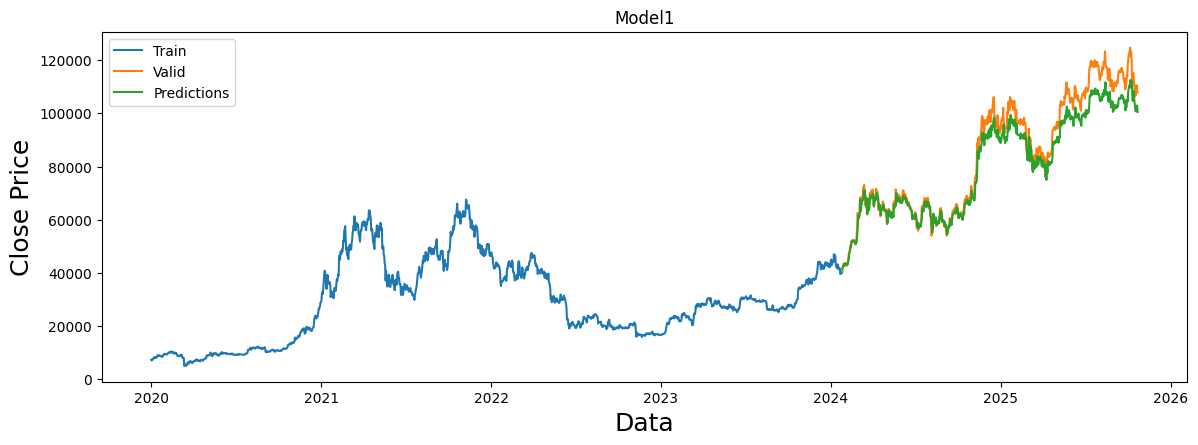

In [71]:
#plotting the results
train = df[:training_data_len]
valid_1 = df[training_data_len:]
valid_1['Predictions'] = predictions_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model1')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.show()

In [49]:
#getting directional predictions
predicted_directions = []
close_col_index = feature_cols.get_loc('Close') if isinstance(feature_cols, pd.Index) else feature_cols.index('Close')

for i in range(len(X_test)):

    last_close_price_scaled = X_test[i, -1, close_col_index]

    dummy = np.zeros((1, len(feature_cols)))
    dummy[0, close_col_index] = last_close_price_scaled
    last_close_price = scaler.inverse_transform(dummy)[0, close_col_index]

    prediction_scaled = model.predict(X_test[i:i+1])       # prediction for the ith test example
    dummy_prediction = np.zeros((1, len(feature_cols)))
    dummy_prediction[0, close_col_index] = prediction_scaled[0, 0]
    predicted_price = scaler.inverse_transform(dummy_prediction)[0, close_col_index]
    if predicted_price > last_close_price:
        predicted_directions.append(1)
    else:
        predicted_directions.append(0)

predicted_directions = np.array(predicted_directions)
print("Predicted Directions shape:", predicted_directions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [52]:
#getting the actual directional changes
actual_directions = []
close_col_index = feature_cols.get_loc('Close') if isinstance(feature_cols, pd.Index) else feature_cols.index('Close')
for i in range(1, len(X_test)):
    last_close_price_scaled = X_test[i-1, -1, close_col_index]      # closing value of the last timestamp
    dummy_prev = np.zeros((1, len(feature_cols)))
    dummy_prev[0, close_col_index] = last_close_price_scaled
    last_close_price = scaler.inverse_transform(dummy_prev)[0, close_col_index]     #applying inverse transform

    current_day_close_price_scaled = X_test[i, 1, close_col_index]
    dummy_curr = np.zeros((1, len(feature_cols)))
    dummy_curr[0, close_col_index] = current_day_close_price_scaled
    current_day_close_price = scaler.inverse_transform(dummy_curr)[0, close_col_index]

    if current_day_close_price > last_close_price:
        actual_directions.append(1)
    else:
        actual_directions.append(0)

actual_directions = np.array(actual_directions)

min_len = min(len(actual_directions), len(predicted_directions))         #storing the minimum length
actual_directions = actual_directions[:min_len]
predicted_directions = predicted_directions[:min_len]

correct_predictions = np.sum(predicted_directions == actual_directions)
directional_accuracy = (correct_predictions / len(actual_directions)) * 100

print(f"Directional Accuracy: {directional_accuracy:.2f}%")

Directional Accuracy: 66.30%
